<a href="https://colab.research.google.com/github/kavinponnusamy01/Novintix-/blob/main/Wind_Turbine_Scada.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Wind Turbine Scada Performance Analysis**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Load the dataset
df = pd.read_csv('T1.csv')

# Convert Date/Time to datetime
df['Date/Time'] = pd.to_datetime(df['Date/Time'], format='%d %m %Y %H:%M')
df = df.sort_values('Date/Time').reset_index(drop=True)

print("Dataset Overview:")
print(f"Shape: {df.shape}")
print(f"Date Range: {df['Date/Time'].min()} to {df['Date/Time'].max()}")
print("\nMissing Values:")
print(df.isnull().sum())
print("\nData Types:")
print(df.dtypes)


Dataset Overview:
Shape: (50530, 5)
Date Range: 2018-01-01 00:00:00 to 2018-12-31 23:50:00

Missing Values:
Date/Time                        0
LV ActivePower (kW)              0
Wind Speed (m/s)                 0
Theoretical_Power_Curve (KWh)    0
Wind Direction (°)               0
dtype: int64

Data Types:
Date/Time                        datetime64[ns]
LV ActivePower (kW)                     float64
Wind Speed (m/s)                        float64
Theoretical_Power_Curve (KWh)           float64
Wind Direction (°)                      float64
dtype: object



TASK 1 - EXPLORATORY DATA ANALYSIS


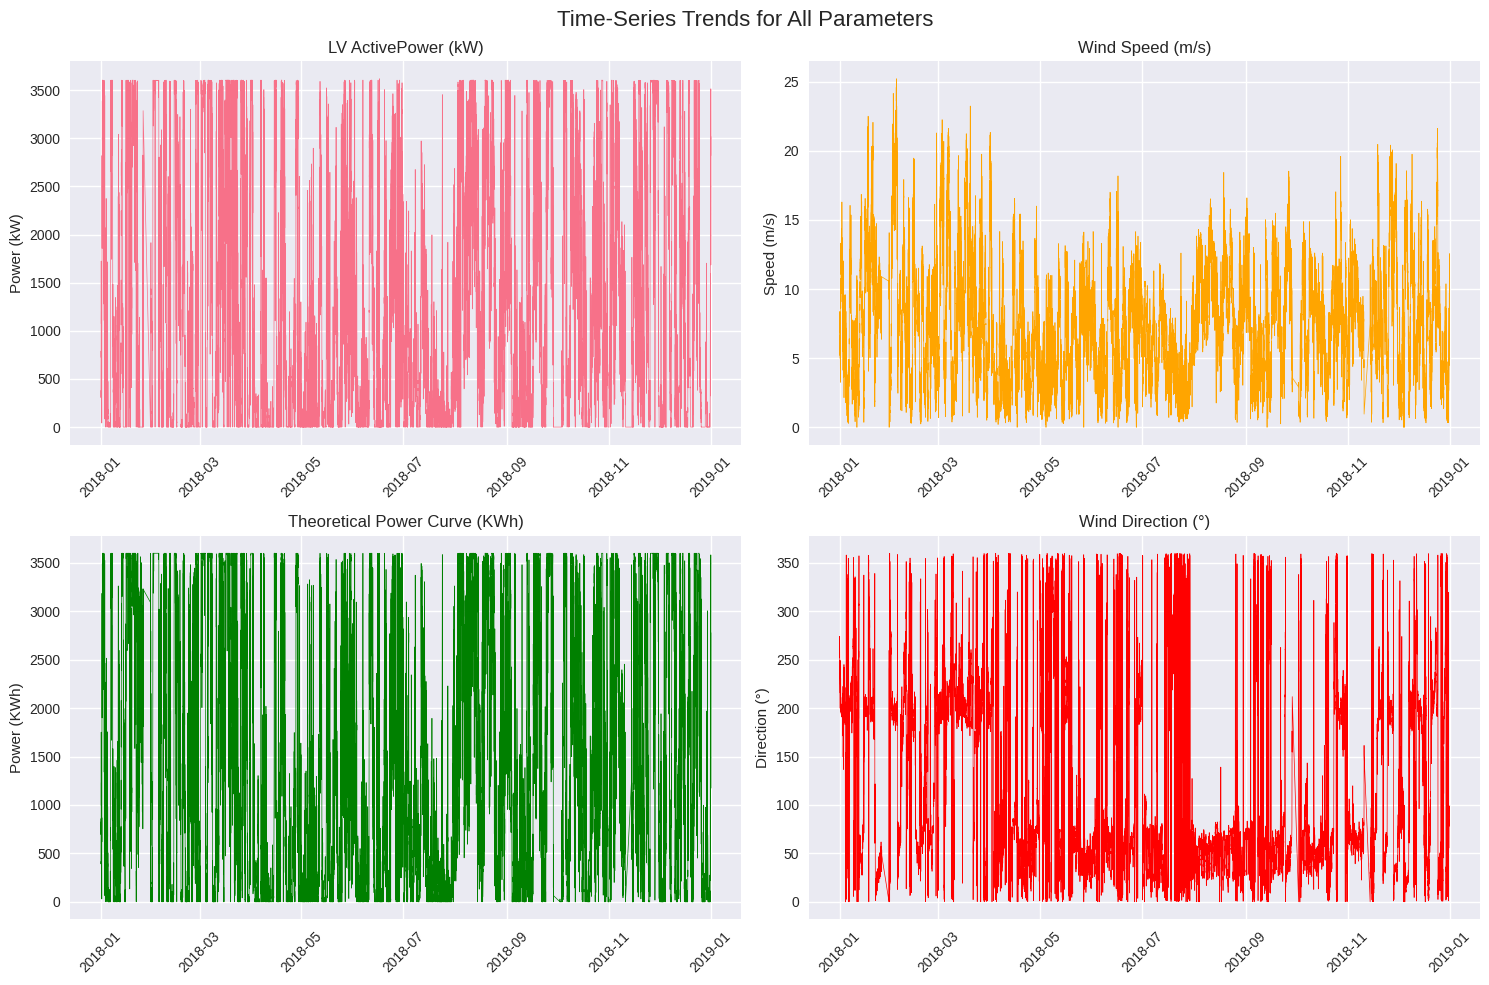

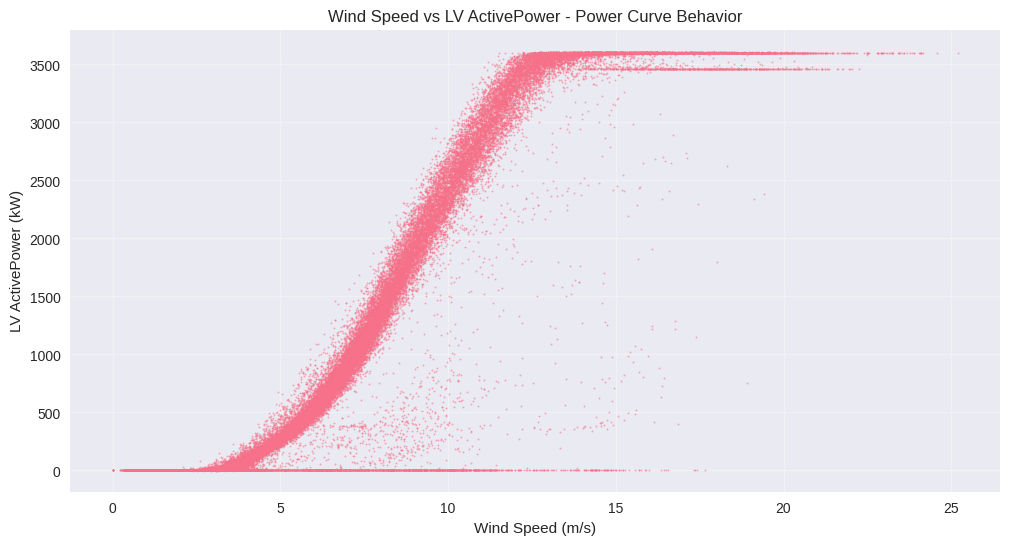


Abnormal Readings Analysis:
Negative Power Values: 57
Zero Power Values: 10781
Negative Wind Speed: 0


In [3]:
# Task 1 — EDA
print("\n" + "="*50)
print("TASK 1 - EXPLORATORY DATA ANALYSIS")
print("="*50)

# 1.1 Time-series trends for all four parameters
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Time-Series Trends for All Parameters', fontsize=16)

# LV ActivePower
axes[0,0].plot(df['Date/Time'], df['LV ActivePower (kW)'], linewidth=0.5)
axes[0,0].set_title('LV ActivePower (kW)')
axes[0,0].set_ylabel('Power (kW)')
axes[0,0].tick_params(axis='x', rotation=45)

# Wind Speed
axes[0,1].plot(df['Date/Time'], df['Wind Speed (m/s)'], linewidth=0.5, color='orange')
axes[0,1].set_title('Wind Speed (m/s)')
axes[0,1].set_ylabel('Speed (m/s)')
axes[0,1].tick_params(axis='x', rotation=45)

# Theoretical Power Curve
axes[1,0].plot(df['Date/Time'], df['Theoretical_Power_Curve (KWh)'], linewidth=0.5, color='green')
axes[1,0].set_title('Theoretical Power Curve (KWh)')
axes[1,0].set_ylabel('Power (KWh)')
axes[1,0].tick_params(axis='x', rotation=45)

# Wind Direction
axes[1,1].plot(df['Date/Time'], df['Wind Direction (°)'], linewidth=0.5, color='red')
axes[1,1].set_title('Wind Direction (°)')
axes[1,1].set_ylabel('Direction (°)')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# 1.2 Scatterplot: Wind Speed vs LV ActivePower
plt.figure(figsize=(12, 6))
plt.scatter(df['Wind Speed (m/s)'], df['LV ActivePower (kW)'], alpha=0.5, s=1)
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('LV ActivePower (kW)')
plt.title('Wind Speed vs LV ActivePower - Power Curve Behavior')
plt.grid(True, alpha=0.3)
plt.show()

# Check for abnormal readings
print("\nAbnormal Readings Analysis:")
print(f"Negative Power Values: {len(df[df['LV ActivePower (kW)'] < 0])}")
print(f"Zero Power Values: {len(df[df['LV ActivePower (kW)'] == 0])}")
print(f"Negative Wind Speed: {len(df[df['Wind Speed (m/s)'] < 0])}")


TASK 2 - TIME-SERIES FORECASTING (SIMPLIFIED)

Training model for: LV ActivePower (kW)
Metrics for LV ActivePower (kW):
MAE: 1360.29
RMSE: 1645.14
R²: -0.5027


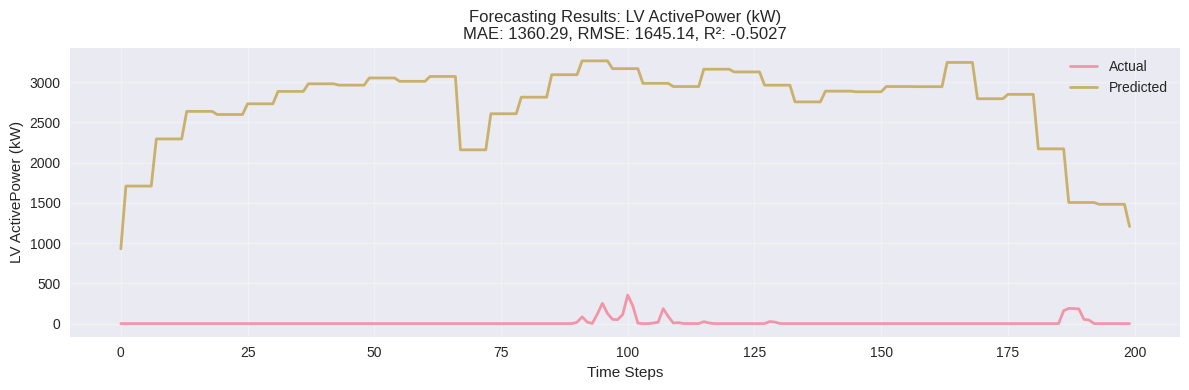


Training model for: Wind Speed (m/s)
Metrics for Wind Speed (m/s):
MAE: 3.83
RMSE: 4.88
R²: -0.2980


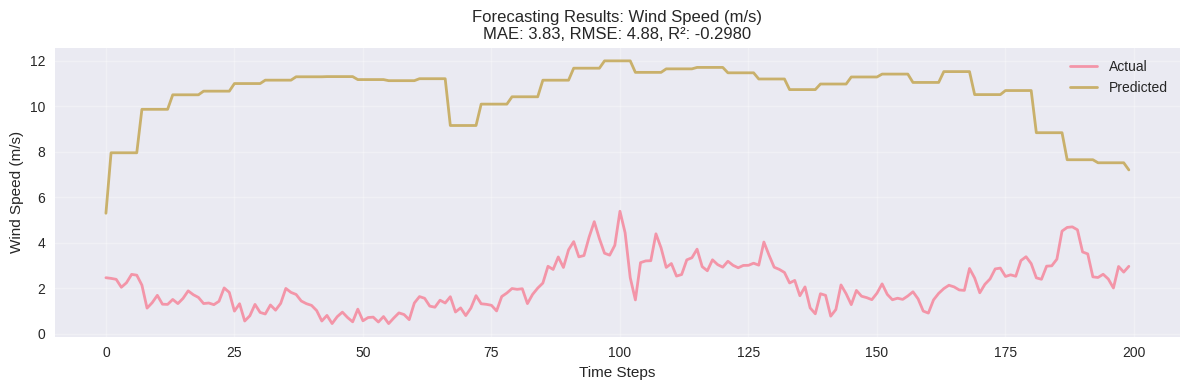


Training model for: Theoretical_Power_Curve (KWh)
Metrics for Theoretical_Power_Curve (KWh):
MAE: 1364.50
RMSE: 1655.58
R²: -0.4741


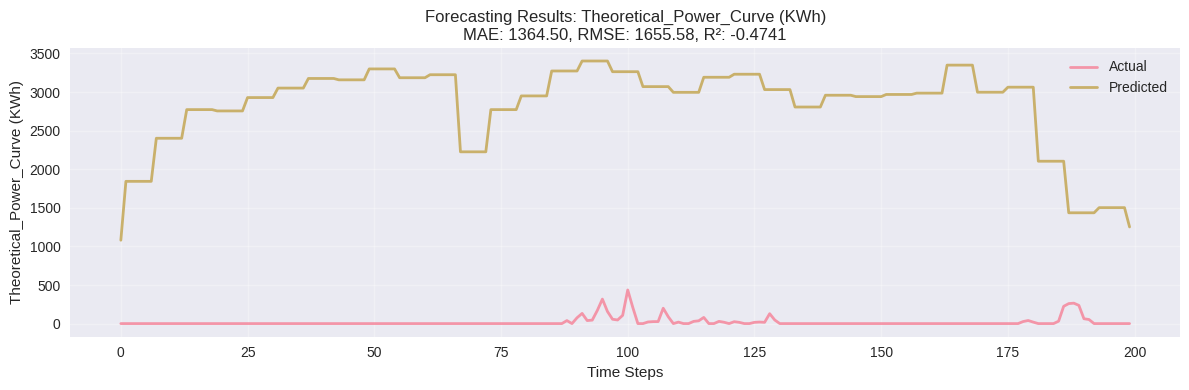


Training model for: Wind Direction (°)
Metrics for Wind Direction (°):
MAE: 87.37
RMSE: 113.95
R²: -0.6113


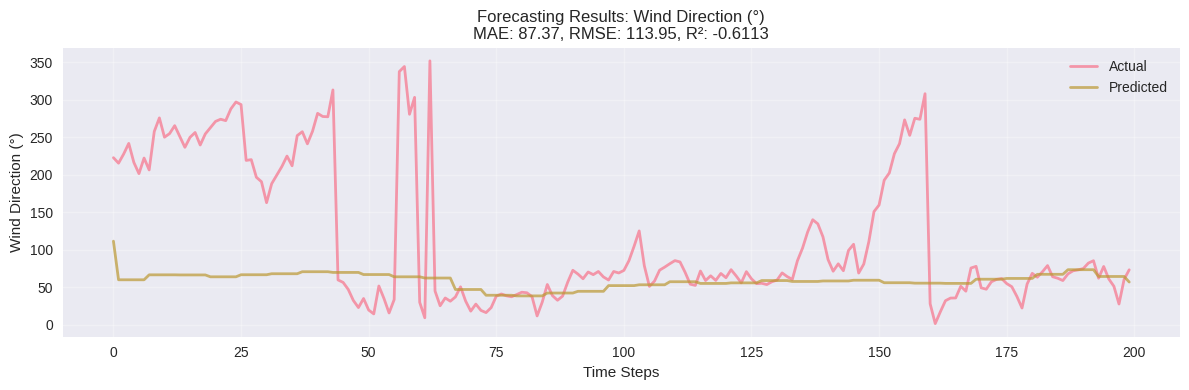

In [9]:
# Task 2 — Supervised Learning (Time-Series Forecasting) - SIMPLIFIED
print("\n" + "="*50)
print("TASK 2 - TIME-SERIES FORECASTING (SIMPLIFIED)")
print("="*50)

# Let's use a simpler approach with Random Forest for faster training
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

def create_features_with_lags(df, target_col, lags=6):
    """Create features with lagged values for time series forecasting"""
    data = df.copy()

    # Create lag features
    for i in range(1, lags + 1):
        data[f'{target_col}_lag_{i}'] = data[target_col].shift(i)

    # Add time-based features
    data['hour'] = data['Date/Time'].dt.hour
    data['dayofweek'] = data['Date/Time'].dt.dayofweek
    data['month'] = data['Date/Time'].dt.month

    # Drop rows with NaN values from lagging
    data = data.dropna()

    return data

# Parameters to forecast
target_columns = ['LV ActivePower (kW)', 'Wind Speed (m/s)',
                'Theoretical_Power_Curve (KWh)', 'Wind Direction (°)']

# Train models for each target variable
forecast_results = {}

for target in target_columns:
    print(f"\nTraining model for: {target}")

    # Create features
    data_with_features = create_features_with_lags(df, target, lags=6)

    # Prepare features and target
    feature_cols = [col for col in data_with_features.columns if col.endswith('_lag_')] + ['hour', 'dayofweek', 'month']
    X = data_with_features[feature_cols]
    y = data_with_features[target]

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

    # Train Random Forest model
    model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"Metrics for {target}:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.4f}")

    # Store results
    forecast_results[target] = {
        'model': model,
        'y_test': y_test,
        'y_pred': y_pred,
        'metrics': {'MAE': mae, 'RMSE': rmse, 'R2': r2}
    }

    # Plot predictions vs actual (first 200 points for clarity)
    plt.figure(figsize=(12, 4))

    plot_points = min(200, len(y_test))
    plt.plot(y_test.values[:plot_points], label='Actual', alpha=0.7, linewidth=2)
    plt.plot(y_pred[:plot_points], label='Predicted', alpha=0.7, linewidth=2)
    plt.title(f'Forecasting Results: {target}\nMAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}')
    plt.ylabel(target)
    plt.xlabel('Time Steps')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


TASK 3 - ANOMALY DETECTION
Number of anomalies detected: 2527
Anomaly percentage: 5.00%


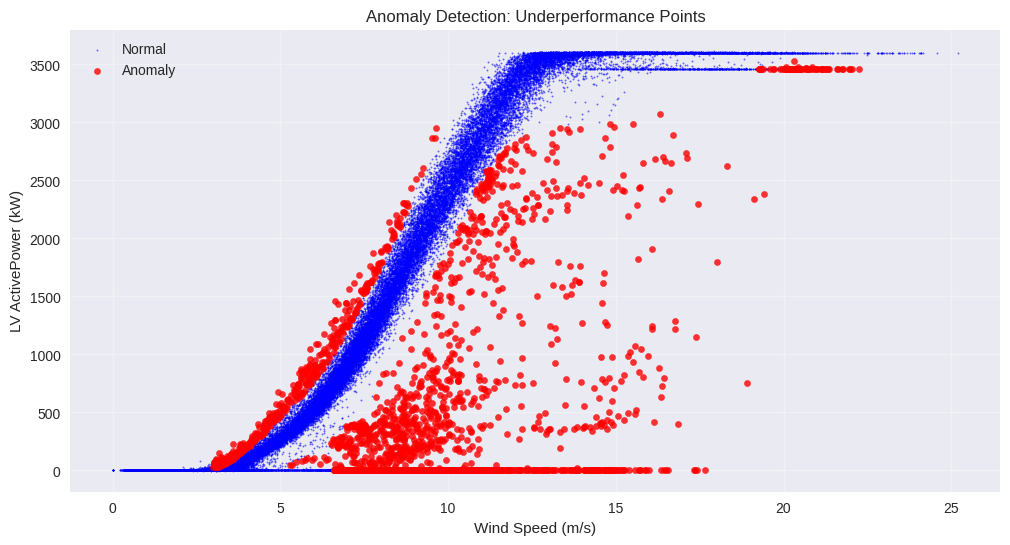

In [6]:
# Task 3 — Unsupervised Learning (Anomaly Detection)
print("\n" + "="*50)
print("TASK 3 - ANOMALY DETECTION")
print("="*50)

# Calculate power deviation
df['Power_Deviation'] = df['LV ActivePower (kW)'] - df['Theoretical_Power_Curve (KWh)']
df['Power_Ratio'] = df['LV ActivePower (kW)'] / df['Theoretical_Power_Curve (KWh)']
df['Power_Ratio'] = df['Power_Ratio'].replace([np.inf, -np.inf], np.nan)
df['Power_Ratio'] = df['Power_Ratio'].fillna(0)

# Prepare features for anomaly detection
anomaly_features = df[['LV ActivePower (kW)', 'Wind Speed (m/s)',
                      'Theoretical_Power_Curve (KWh)', 'Power_Deviation', 'Power_Ratio']].copy()

# Handle infinite values
anomaly_features = anomaly_features.replace([np.inf, -np.inf], np.nan)
anomaly_features = anomaly_features.fillna(anomaly_features.median())

# Use Isolation Forest for anomaly detection
iso_forest = IsolationForest(contamination=0.05, random_state=42)  # 5% contamination
anomaly_predictions = iso_forest.fit_predict(anomaly_features)

df['Anomaly_Flag'] = anomaly_predictions
df['Is_Anomaly'] = df['Anomaly_Flag'] == -1

print(f"Number of anomalies detected: {df['Is_Anomaly'].sum()}")
print(f"Anomaly percentage: {df['Is_Anomaly'].mean()*100:.2f}%")

# Plot anomalies
plt.figure(figsize=(12, 6))
normal_data = df[~df['Is_Anomaly']]
anomaly_data = df[df['Is_Anomaly']]

plt.scatter(normal_data['Wind Speed (m/s)'], normal_data['LV ActivePower (kW)'],
           alpha=0.5, s=1, label='Normal', c='blue')
plt.scatter(anomaly_data['Wind Speed (m/s)'], anomaly_data['LV ActivePower (kW)'],
           alpha=0.8, s=20, label='Anomaly', c='red')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('LV ActivePower (kW)')
plt.title('Anomaly Detection: Underperformance Points')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


TASK 4 - AI TURBINE PERFORMANCE SCORE GENERATOR

Performance Category Summary:
Performance_Category
Good        31606
Poor        13288
Moderate     5636
Name: count, dtype: int64

Overall Average Performance Score: 67.44


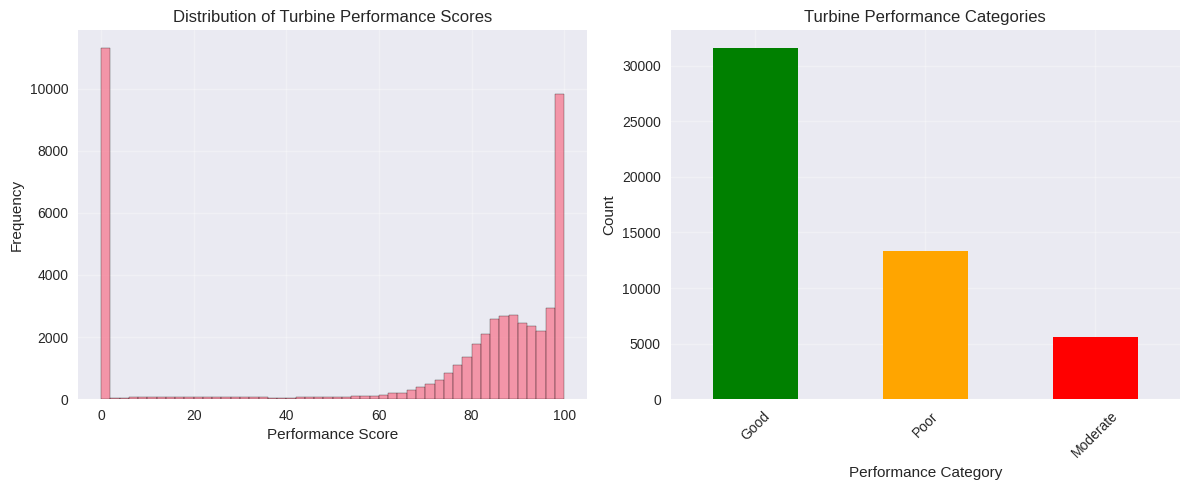


Sample Performance Results:
          Date/Time  LV ActivePower (kW)  Theoretical_Power_Curve (KWh)  Performance_Score Performance_Category                                         Suggestion
2018-09-13 19:50:00             0.000000                       0.000000           0.000000                 Poor  Poor performance. Immediate maintenance required.
2018-09-26 18:20:00          3600.837891                    3600.000000         100.000000                 Good Optimal performance. Continue regular maintenance.
2018-08-22 03:00:00          2150.631104                    2726.044647          78.891999             Moderate    Moderate performance. Schedule inspection soon.
2018-10-23 08:30:00          1518.640015                    1668.704697          91.007116                 Good Optimal performance. Continue regular maintenance.
2018-12-16 20:20:00             0.000000                      17.359931           0.000000                 Poor  Poor performance. Immediate maintenance req

In [7]:
# Task 4 — AI Turbine Performance Score Generator
print("\n" + "="*50)
print("TASK 4 - AI TURBINE PERFORMANCE SCORE GENERATOR")
print("="*50)

def calculate_performance_score(df):
    """Calculate performance score and categorize turbine state"""

    # Calculate performance ratio (avoiding division by zero)
    performance_ratio = df['LV ActivePower (kW)'] / df['Theoretical_Power_Curve (KWh)']
    performance_ratio = performance_ratio.replace([np.inf, -np.inf], np.nan)

    # Fill NaN values with 0 (for zero theoretical power cases)
    performance_ratio = performance_ratio.fillna(0)

    # Clip ratio to reasonable bounds
    performance_ratio = np.clip(performance_ratio, 0, 1.2)

    # Convert to score 0-100
    performance_score = performance_ratio * 100
    performance_score = np.clip(performance_score, 0, 100)

    # Categorize performance
    conditions = [
        performance_score >= 80,
        performance_score >= 60,
        performance_score < 60
    ]
    choices = ['Good', 'Moderate', 'Poor']

    performance_category = np.select(conditions, choices, default='Poor')

    # Generate suggestions
    suggestions = []
    for score, category in zip(performance_score, performance_category):
        if category == 'Good':
            suggestion = "Optimal performance. Continue regular maintenance."
        elif category == 'Moderate':
            suggestion = "Moderate performance. Schedule inspection soon."
        else:
            suggestion = "Poor performance. Immediate maintenance required."
        suggestions.append(suggestion)

    return performance_score, performance_category, suggestions

# Calculate performance metrics
performance_score, performance_category, suggestions = calculate_performance_score(df)

df['Performance_Score'] = performance_score
df['Performance_Category'] = performance_category
df['Suggestion'] = suggestions

# Display performance summary
performance_summary = df['Performance_Category'].value_counts()
print("\nPerformance Category Summary:")
print(performance_summary)

print(f"\nOverall Average Performance Score: {df['Performance_Score'].mean():.2f}")

# Plot performance distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
df['Performance_Score'].hist(bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Performance Score')
plt.ylabel('Frequency')
plt.title('Distribution of Turbine Performance Scores')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
performance_summary.plot(kind='bar', color=['green', 'orange', 'red'])
plt.xlabel('Performance Category')
plt.ylabel('Count')
plt.title('Turbine Performance Categories')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Display sample results
print("\nSample Performance Results:")
sample_results = df[['Date/Time', 'LV ActivePower (kW)', 'Theoretical_Power_Curve (KWh)',
                    'Performance_Score', 'Performance_Category', 'Suggestion']].sample(10)
print(sample_results.to_string(index=False))

# Generate final report
print("\n" + "="*50)
print("FINAL PERFORMANCE REPORT")
print("="*50)
print(f"Total Data Points: {len(df)}")
print(f"Average Performance Score: {df['Performance_Score'].mean():.2f}")
print(f"Best Performance Score: {df['Performance_Score'].max():.2f}")
print(f"Worst Performance Score: {df['Performance_Score'].min():.2f}")
print(f"\nPerformance Distribution:")
print(f"Good: {len(df[df['Performance_Category'] == 'Good'])} ({len(df[df['Performance_Category'] == 'Good'])/len(df)*100:.1f}%)")
print(f"Moderate: {len(df[df['Performance_Category'] == 'Moderate'])} ({len(df[df['Performance_Category'] == 'Moderate'])/len(df)*100:.1f}%)")
print(f"Poor: {len(df[df['Performance_Category'] == 'Poor'])} ({len(df[df['Performance_Category'] == 'Poor'])/len(df)*100:.1f}%)")

# Save results
df.to_csv('turbine_analysis_results.csv', index=False)
print("\nResults saved to 'turbine_analysis_results.csv'")